In [1]:
# Import necessary libraries
import csv  # For reading and writing CSV files
import json  # For reading JSON files
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

import seaborn as sns  # For data visualization
from sklearn.linear_model import LogisticRegression  # For logistic regression model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay  # For model evaluation metrics
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.impute import SimpleImputer  # For handling missing values

import matplotlib.pyplot as plt  # For plotting


## Task Initialization and Feature Selection

In [2]:
# Read in the data
train_set = pd.read_csv('Data/train_processed.csv')
dev_set = pd.read_csv('Data/dev_processed.csv')
test_set = pd.read_csv('Data/test_processed.csv')

# Feature columns
columns_1 = ['issue_area_Attorneys', 'issue_area_Civil Rights', 'issue_area_Criminal Procedure', 'issue_area_Due Process', 'issue_area_Economic Activity', 'issue_area_Federal Taxation', 'issue_area_Federalism', 'issue_area_First Amendment', 'issue_area_Interstate Relations', 'issue_area_Judicial Power', 'issue_area_Miscellaneous', 'issue_area_Privacy', 'issue_area_Private Action', 'issue_area_UNKNOWN', 'issue_area_Unions',
            'file_year_2000_2010', 'file_year_2010_2020', 'file_year_before_2000', 'argument_quarter_1.0', 'argument_quarter_2.0', 'argument_quarter_3.0', 'argument_quarter_4.0', 'argument_quarter_nan',
            'court_hearing_length', 'utterances_number','lagged_time', 'speech_rate',]
columns_2 = ['successful_appeal']

# Filter the columns for the train and dev sets
final_columns = columns_1 + [f'embedding_{i}' for i in range(1, 385)] + columns_2
train_set = train_set[final_columns]
dev_set = dev_set[final_columns]

# Filter the columns for the test set
final_columns.remove('successful_appeal')
test_set = test_set[final_columns]

In [3]:
# Split the data into features (X) and target (y)
X_train = train_set.drop('successful_appeal', axis=1).values
y_train = train_set['successful_appeal'].values

X_dev = dev_set.drop('successful_appeal', axis=1).values
y_dev = dev_set['successful_appeal'].values

X_test = test_set.values  # Test set doesn't have the target variable

In [4]:
# Create an imputer object to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to X_test
X_test = imputer.fit_transform(X_test)

# Check for missing values in X_test
print("Missing values in test set:", np.isnan(X_test).sum())


Missing values in test set: 0


## Train the Logistic Regression Model

### Tune Hyperparameters with Grid Search

In [5]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l2' is the default penalty for Logistic Regression
    'solver': ['lbfgs', 'liblinear']  # Two common solvers that support regularization
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', verbose=1)

# Apply GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters found during cross-validation
print(f"Best hyperparameters found: {grid_search.best_params_}")

# Get the best estimator (model) after tuning
best_log_reg_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


## Evaluate the Logistic Regression Model on the Dev Set

In [6]:
# Evaluate the best model on the dev set
y_pred_dev = best_log_reg_model.predict(X_dev)
y_prob_dev = best_log_reg_model.predict_proba(X_dev)[:, 1]  # Probability for the positive class

# Print classification report for the dev set
print("Logistic Regression Performance on Dev Set (after cross-validation):")
print(classification_report(y_dev, y_pred_dev))

# ROC-AUC Score for the dev set
roc_auc = roc_auc_score(y_dev, y_prob_dev)
print(f"ROC-AUC on Dev Set: {roc_auc:.4f}")


Logistic Regression Performance on Dev Set (after cross-validation):
              precision    recall  f1-score   support

         0.0       0.42      0.13      0.20       210
         1.0       0.64      0.90      0.75       367

    accuracy                           0.62       577
   macro avg       0.53      0.51      0.47       577
weighted avg       0.56      0.62      0.55       577

ROC-AUC on Dev Set: 0.5402


### Visualization

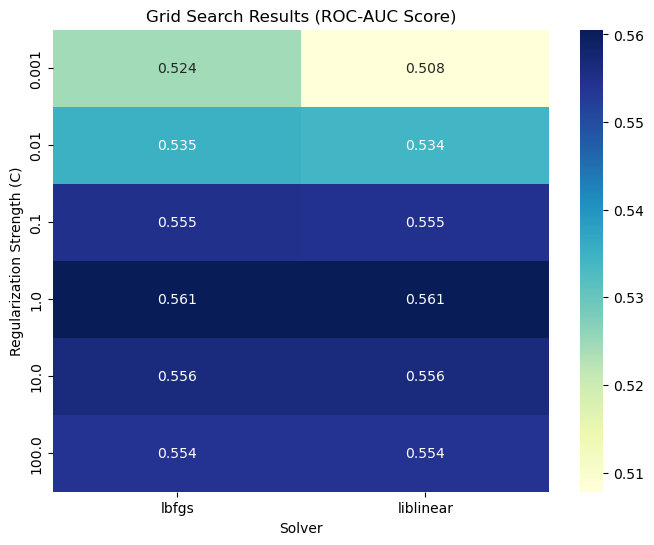

In [7]:
# After running the grid search, you can extract the results:
cv_results = grid_search.cv_results_

# Extract the relevant metrics
mean_test_scores = cv_results['mean_test_score']  # Mean ROC-AUC scores for each parameter combination
std_test_scores = cv_results['std_test_score']    # Standard deviation of ROC-AUC scores
param_C = cv_results['param_C'].data              # Regularization strength (C)
param_solver = cv_results['param_solver'].data    # Solver

# Convert to NumPy arrays for easier processing
mean_test_scores = np.array(mean_test_scores)
std_test_scores = np.array(std_test_scores)
param_C = np.array(param_C, dtype=float)  # Convert to float for numerical processing
param_solver = np.array(param_solver)

# Create a pivot table (C values vs solver) for visualization purposes
# This is assuming that you have a 2D parameter grid with C and solver
results_matrix = np.zeros((len(np.unique(param_C)), len(np.unique(param_solver))))

# Populate the matrix with the mean scores
for i, solver in enumerate(np.unique(param_solver)):
    for j, C in enumerate(np.unique(param_C)):
        mask = (param_solver == solver) & (param_C == C)
        results_matrix[j, i] = mean_test_scores[mask]

# Plot a heatmap to visualize the performance of different hyperparameter combinations
plt.figure(figsize=(8, 6))
sns.heatmap(results_matrix, annot=True, fmt='.3f', xticklabels=np.unique(param_solver), yticklabels=np.unique(param_C), cmap="YlGnBu")
plt.title("Grid Search Results (ROC-AUC Score)")
plt.xlabel("Solver")
plt.ylabel("Regularization Strength (C)")
plt.show()


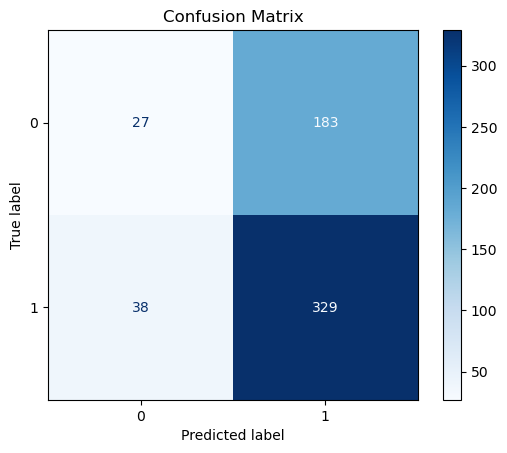

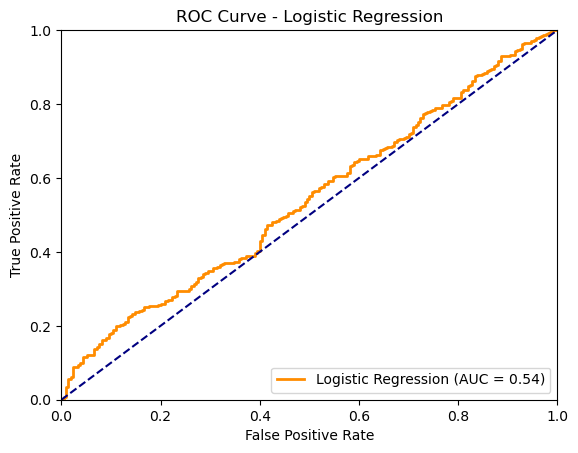

In [8]:
# Confusion Matrix
binary_preds = ( y_prob_dev > 0.5).astype(int)
cm = confusion_matrix(y_dev, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_dev, y_prob_dev)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Make Predictions on the Test Set

In [9]:
# Make predictions on the test set (best model if tuned, else original model)
y_pred_test = best_log_reg_model.predict(X_test)
y_prob_test = best_log_reg_model.predict_proba(X_test)[:, 1]  # Use probabilities for final prediction if necessary


In [10]:
# Save predictions to a CSV file
def save_pred(preds, case_ids, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['case_id', 'successful_appeal'])
        for case_id, p in zip(case_ids, preds):
            p = int(p >= 0.5)  # Convert probabilities to binary predictions (threshold at 0.5)
            writer.writerow([case_id, p])


# Load case IDs from the test.jsonl file
def load_case_ids(jsonl_file):
    ''' Load case_ids from the test.jsonl file '''
    case_ids = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            case_ids.append(data['case_id'])
    return case_ids

# Load case IDs from the original test.jsonl file
test_jsonl_file = 'Data/test.jsonl'  
case_ids = load_case_ids(test_jsonl_file)

# Save predictions with real case_ids
save_pred(y_prob_test, case_ids, 'LR-pred.csv')

Saving results to LR-pred.csv
